In [2]:
import scipy.constants as C
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
# import typing_extensions
# from typing import Self

$pV = \nu RT$; $\nu = pV / RT$

In [3]:
5120 * np.pi * C.G**2 / C.c**4 / C.hbar * (1e6)**3 # black hole total evaporation speed
C.hbar * C.c**3 / 8 / np.pi / C.G / 1e6 / C.k # black hole temperature

1.2269006705940171e+17

In [291]:
Cvs = np.array([20, 20, 200])
gases = ['N2', 'O2', 'Exotic']
mus = [28, 32, 405]

In [300]:
class GasQty:
    moles: np.ndarray
    T: float
    V: float
    x: int
    @classmethod
    def mk_pressure(cls, T: float, V: float = 2.5, p: float = 101325, Xs: list[float] = [0.79, 0.21, 0]):
        xs = np.array(Xs)
        n = p*V/C.R/T 
        return GasQty(T, V, 1, n * xs)
    def __init__(self, T: float, V: float = 2.5, x = 1, moles: list[float] = [22.4, 0, 0]):
        self.T = T
        self.V = V
        self.x = x
        self.moles = np.array(moles)
    def split_p(self, frac: float): # -> Self:
        """keeeping the pressure constants, splits a frac of volume to new obj"""
        mx = self.moles * frac
        vx = self.V * frac
        self.moles -= mx / self.x 
        self.V -= vx / self.x 
        return GasQty(self.T, vx, 1, mx)
    @property
    def N(self):
        """Moles total"""
        return self.moles.sum()
    @property
    def X(self):
        """Molar fractions"""
        return dict(zip(gases, self.moles / self.N if self.N > 0 else np.zeros_like(self.moles))) 
    @property
    def p(self):
        """Ideal gas pressure"""
        return self.N * C.R * self.T / self.V
    @property
    def Cv(self):
        """Heat capacity of this constant volume, J/K"""
        return Cvs @ self.moles
    def merge(self, other):
        Q0 = self.Cv * self.T * self.x
        Q1 = other.Cv * other.T * other.x
        self.moles += other.moles * other.x / self.x
        self.T = (Q0 + Q1) / self.Cv
        self.V += other.V
        other.moles *= 0
        other.T = 0
        other.V = 0
        del other
    @property
    def epr(self):
        return self.N/(self.V/2.5)/self.x/23.1
    def __mul__(self, x: int):
        return GasQty(self.T, self.V, self.x*x, self.moles)
    def __repr__(self) -> str:
        return f'GasQty(T={self.T}, V={self.V}, x={self.x}, moles={list(self.moles)})'

In [301]:
class SupermatterCore:
    gas_eff = 0.25 # 1
    decay = 700   # Pa^[2/3]???
    reaction = 1.1 # `reaction_power_modified`
    k_thermal = 10e3
    k_exotic = 15e2
    k_o2 = 15e3
    k_n2_ret = 0.15 # 1
    k_damage = 4.5e-3 # scaled by 1000
    T_crit = 5000 # K

    damage: float # scaled by 1000 to 0..1 interval; integrity = 1-damage
    power: float # EER, MeV / cm3 -- meaningless!

    def __init__(self, damage = 0, power = 0):
        self.damage = damage
        self.power = power

    def powerup(self, dmg: float):
        self.power += dmg/10.
    
    def tick_damage(self, N: float, T: float) -> bool:
        if N == 0:
            self.damage += max((self.power - 15)/10e3, 0)
            return True
        max_dmg = SupermatterCore.k_damage * self.power/300
        techn_dmg = (T - SupermatterCore.T_crit) / 150e3
        self.damage = max(0, self.damage + np.clip(techn_dmg, -SupermatterCore.k_damage, max_dmg))
        return False

    def react(self, o2: float, n2: float, T: float) -> float:
        o2_eff = max(o2 - SupermatterCore.k_n2_ret * n2, 0)
        P_eq = 250 if o2_eff <= 0.8 else 400 # Target equilibrium power?
        fT = T/800 * (P_eq / SupermatterCore.decay)**3
        return o2_eff * fT + self.power

    def tick(self, air: GasQty) -> GasQty:
        if self.damage >= 1:
            air.moles = np.array([0, 0, 0]) # exploded
            air.T = 0
            return air
        if self.tick_damage(air.N, air.T):
            return air
        P = self.react(air.X['O2'], air.X['N2'], air.T)
        
        E = P * SupermatterCore.reaction # ????
        new_Ex = E / SupermatterCore.k_exotic
        new_O2 = max((E + air.T - 273.15) / SupermatterCore.k_o2, 0)
        
        reag = air.split_p(SupermatterCore.gas_eff)
        reag.moles += [0, new_O2, new_Ex]
        reag.T += E * SupermatterCore.k_thermal / reag.Cv
        if reag.T > 10e3: reag.T = 10e3
        air.merge(reag)
        
        self.power = P - (P/SupermatterCore.decay)**3
        return air        

In [308]:
(GasQty.mk_pressure(300) * 2).epr

2.1981595192873056

In [289]:
core_air = GasQty.mk_pressure(300)*15 #, p=300e3, Xs=[1,0,0])
core = SupermatterCore(0,14)
ret = []
for t in range(2000):
    ret.append([t/10., core.power, core_air.N/core_air.x/23.1, core_air.p, core_air.T, core.damage, *(core_air.X.values()), *(core_air.moles)])
    core_air = core.tick(core_air)
    # core_air.moles[1] = 0
ret = np.array(ret)

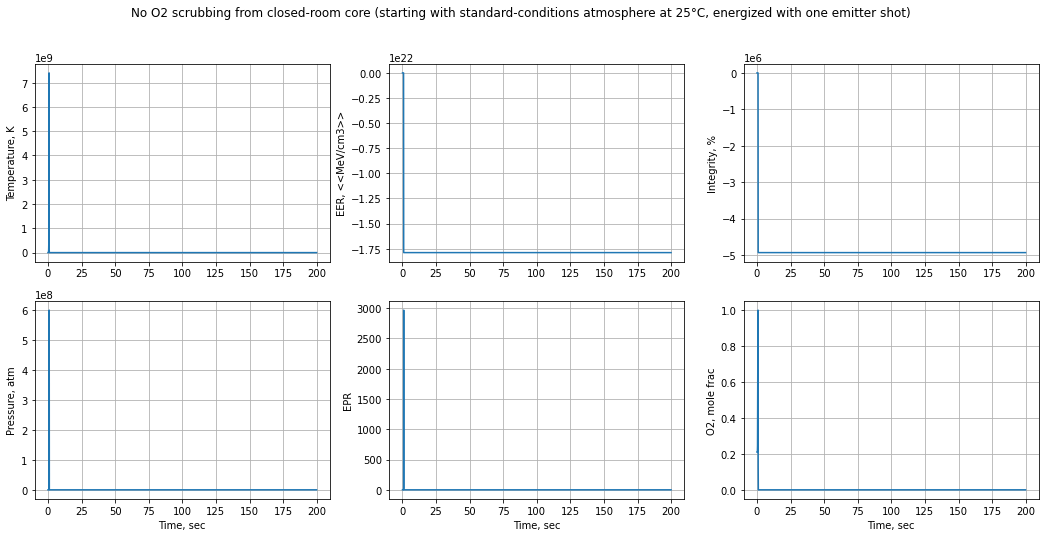

In [290]:
f, ax = plt.subplots(2, 3, figsize=(18, 8))
f.suptitle('No O2 scrubbing from closed-room core (starting with standard-conditions atmosphere at 25°C, energized with one emitter shot)')
ax[0, 0].plot(ret[:, 0], ret[:, 4])
ax[0, 0].set_ylabel('Temperature, K')
ax[1, 0].plot(ret[:, 0], ret[:, 3]/101325)
ax[1, 0].set_ylabel('Pressure, atm')
ax[1, 0].set_xlabel('Time, sec')

ax[0, 1].plot(ret[:, 0], ret[:, 1])
ax[0, 1].set_ylabel('EER, <<MeV/cm3>>')
ax[1, 1].plot(ret[:, 0], ret[:, 2])
ax[1, 1].set_ylabel('EPR')
ax[1, 1].set_xlabel('Time, sec')

ax[0, 2].plot(ret[:, 0], (1 - ret[:, 5])*100)
ax[0, 2].set_ylabel('Integrity, %')
ax[1, 2].plot(ret[:, 0], ret[:, 7])
ax[1, 2].set_ylabel('O2, mole frac')
ax[1, 2].set_xlabel('Time, sec')

# ax[1, 2].plot(ret[:, 0], np.cumsum(ret[:, 10] * 0.032))
# ax[1, 2].set_ylabel('O2, kg scrubbed total')
# ax[1, 2].set_xlabel('Time, sec')

for k in ax:
    for c in k:
        c.grid(True)

In [237]:
import cantera as ct    

In [41]:
s = ct.Solution('gri30.yaml')
s.TPX = 300, 1e5, 'N2: 1'
s()


  gri30:

       temperature   300 K
          pressure   1e+05 Pa
           density   1.1231 kg/m^3
  mean mol. weight   28.014 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy              1971             55215  J
   internal energy            -87068       -2.4391e+06  J
           entropy            6846.6         1.918e+05  J/K
    Gibbs function        -2.052e+06       -5.7485e+07  J
 heat capacity c_p            1037.9             29075  J/K
 heat capacity c_v            741.09             20761  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                N2                 1                 1           -23.046
     [  +52 minor]                 0                 0  

